In [1]:
%pip install kaggle torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▉| 810M/812M [00:32<00:00, 23.8MB/s]
100%|████████████████████████████████████████| 812M/812M [00:32<00:00, 26.3MB/s]


In [3]:
!unzip -qq dogs-vs-cats.zip

In [4]:
!unzip -qq train.zip
!unzip -qq test1.zip

In [5]:
CAT_NUM = 12500
DOG_NUM = 12500

train_dir = 'train'
test_dir = 'test1'

In [6]:
import os
import shutil
import random
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from source.model import SimpleNet


/Users/uvuv/CV/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
SEED = 42
TRAIN_RATIO = 0.8
TEST_COUNT = 50
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 5
IMG_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

random.seed(SEED)
torch.manual_seed(SEED)

def prepare_data(source_dir, target_dir):
    if os.path.exists(target_dir):
        return

    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    for split in ['train', 'val', 'test']:
        for cls in ['cat', 'dog']:
            (target_path / split / cls).mkdir(parents=True, exist_ok=True)
            
    files = list(source_path.glob('*.jpg'))
    cats = [f for f in files if 'cat' in f.name]
    dogs = [f for f in files if 'dog' in f.name]
    
    for category_files, cls in [(cats, 'cat'), (dogs, 'dog')]:
        random.shuffle(category_files)
        test_files = category_files[:TEST_COUNT]
        remaining = category_files[TEST_COUNT:]
        split_idx = int(len(remaining) * TRAIN_RATIO)
        train_files = remaining[:split_idx]
        val_files = remaining[split_idx:]
        
        for f in test_files: shutil.copy(f, target_path / 'test' / cls / f.name)
        for f in train_files: shutil.copy(f, target_path / 'train' / cls / f.name)
        for f in val_files: shutil.copy(f, target_path / 'val' / cls / f.name)

prepare_data('train', 'dataset')

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds = datasets.ImageFolder('dataset/train', transform=transform_train)
val_ds = datasets.ImageFolder('dataset/val', transform=transform_val)
test_ds = datasets.ImageFolder('dataset/test', transform=transform_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Training on mps


Epoch 1/5: 100%|██████████| 623/623 [00:40<00:00, 15.20it/s, loss=0.614, acc=65.7]  


Val Loss: 0.6056 | Val Acc: 66.77%


Epoch 2/5: 100%|██████████| 623/623 [00:41<00:00, 15.08it/s, loss=0.544, acc=72.9]  


Val Loss: 0.6000 | Val Acc: 69.66%


Epoch 3/5: 100%|██████████| 623/623 [00:40<00:00, 15.21it/s, loss=0.494, acc=76.6]   


Val Loss: 0.5645 | Val Acc: 70.92%


Epoch 4/5: 100%|██████████| 623/623 [00:41<00:00, 15.01it/s, loss=0.441, acc=80]     


Val Loss: 0.3837 | Val Acc: 82.83%


Epoch 5/5: 100%|██████████| 623/623 [00:41<00:00, 15.13it/s, loss=0.398, acc=82.6]   


Val Loss: 0.3717 | Val Acc: 84.14%


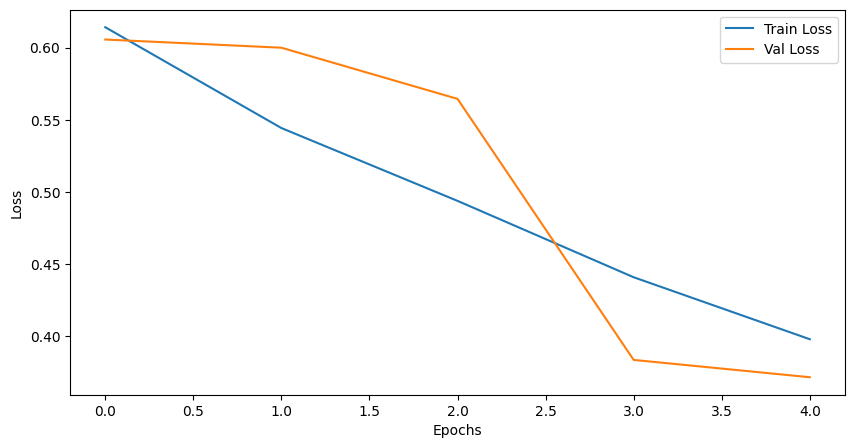

In [9]:
import matplotlib.pyplot as plt

model = SimpleNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

print(f"Training on {DEVICE}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(train_loader), 'acc': 100.*correct/total})
    
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {100.*val_correct/val_total:.2f}%")

torch.save(model.state_dict(), 'model.pth')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.*test_correct/test_total:.2f}%")

Test Accuracy: 83.00%
